In [2]:
# === 03_model_train: universal header + config + loads ===
import sys, yaml
from pathlib import Path

# 1) Make src/ importable regardless of where you opened the notebook
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name.lower() == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.insert(0, str(PROJECT_ROOT / "src"))

# 2) Autoreload for iterative edits
%load_ext autoreload
%autoreload 2

# 3) Imports
from utils import print_run_header, read_parquet
print_run_header("03_model_train")

# 4) Load config
CFG_PATH = PROJECT_ROOT / "configs" / "config.yaml"
assert CFG_PATH.exists(), f"Missing config at {CFG_PATH}"
cfg = yaml.safe_load(CFG_PATH.read_text())

# 5) Load processed artifacts from 02_feature_store
PROC_DIR = PROJECT_ROOT / cfg["paths"]["processed_dir"]

labels_path = PROC_DIR / "labels.parquet"
team_path   = PROC_DIR / "team_features.parquet"
starter_path= PROC_DIR / "starter_features.parquet"
lineup_path = PROC_DIR / "lineup_features.parquet"
pitch_path  = PROC_DIR / "pitch_features.parquet"
pw_path     = PROC_DIR / "park_weather_features.parquet"  # may not exist if weather was skipped

for p in [labels_path, team_path, starter_path, lineup_path, pitch_path]:
    assert p.exists(), f"Missing required file: {p}"

labels = read_parquet(labels_path)
team   = read_parquet(team_path)
starter= read_parquet(starter_path)
lineup = read_parquet(lineup_path)
pitch  = read_parquet(pitch_path)

# Weather/park may be skipped; build a neutral fallback if absent
if pw_path.exists():
    pw = read_parquet(pw_path)
else:
    import pandas as pd
    pw = pd.DataFrame({
        "game_id": labels["game_id"],
        "game_pk": labels["game_pk"],
        "temp_c": 20.0,
        "rel_humidity": 50.0,
        "wind_kph": 8.0,
        "mslp_hpa": 1015.0,
        "park_factor_runs": 1.0,
        "air_density_proxy": 1.0,
    })
    print("Note: using neutral park/weather fallback (no weather features).")

print("Loaded shapes:",
      "labels", labels.shape,
      "team", team.shape,
      "starter", starter.shape,
      "lineup", lineup.shape,
      "pitch", pitch.shape,
      "pw", pw.shape)


=== 03_model_train ===
Python 3.12.7 | pandas 2.3.1 | numpy 2.2.6 | sklearn 1.7.1 | xgboost 3.0.4
Platform: Windows 11 | Time: 2025-08-21 16:08:00
Note: using neutral park/weather fallback (no weather features).
Loaded shapes: labels (8680, 8) team (17360, 4) starter (17360, 4) lineup (8680, 4) pitch (8680, 4) pw (8680, 8)


In [4]:
for nm, df_ in [("labels", labels), ("team", team), ("starter", starter), ("lineup", lineup), ("pitch", pitch), ("pw", pw)]:
    missing = [c for c in ["game_id", "game_pk"] if c not in df_.columns]
    print(nm, "missing:", missing)


labels missing: []
team missing: []
starter missing: []
lineup missing: []
pitch missing: []
pw missing: []


In [6]:
keys = ["game_id", "game_pk"]

def dup_report(df, name):
    dups = df.duplicated(keys).sum()
    uniq = df.drop_duplicates(keys).shape[0]
    print(f"{name:8s}  rows={len(df):5d}  dup_key_rows={dups:5d}  unique_games={uniq}")

for nm, df_ in [("labels", labels), ("team", team), ("starter", starter),
                ("lineup", lineup), ("pitch", pitch), ("pw", pw)]:
    dup_report(df_, nm)


labels    rows= 8680  dup_key_rows=    0  unique_games=8680
team      rows=17360  dup_key_rows= 8680  unique_games=8680
starter   rows=17360  dup_key_rows= 8680  unique_games=8680
lineup    rows= 8680  dup_key_rows=    0  unique_games=8680
pitch     rows= 8680  dup_key_rows=    0  unique_games=8680
pw        rows= 8680  dup_key_rows=    0  unique_games=8680


In [8]:
keys = ["game_id", "game_pk"]

def normalize_keys(df, name):
    # 1) drop exact duplicate-named columns, keep first
    df = df.loc[:, ~df.columns.duplicated(keep="first")].copy()

    # 2) coalesce suffix variants like game_id_x/game_id_y -> game_id
    for base in keys:
        x, y = f"{base}_x", f"{base}_y"
        if x in df.columns or y in df.columns:
            if base not in df.columns:
                df[base] = df.get(x, df.get(y))
            # if both exist, prefer _x but fill from _y where _x is NA
            if x in df.columns and y in df.columns:
                df[base] = df[base].where(~df[base].isna(), df[y])
            df.drop(columns=[c for c in [x, y] if c in df.columns], inplace=True)

        # if somehow there are still multiple columns with the same base name,
        # keep the first one
        if isinstance(df.get(base), pd.DataFrame):
            first = df[base].iloc[:, 0]
            df.drop(columns=[base], inplace=True)
            df[base] = first

    # ensure both keys exist; if not, try to build from the other tables later
    missing = [k for k in keys if k not in df.columns]
    if missing:
        print(f"[{name}] missing keys after normalize:", missing)
    return df

labels  = normalize_keys(labels,  "labels")
team    = normalize_keys(team,    "team")
starter = normalize_keys(starter, "starter")
lineup  = normalize_keys(lineup,  "lineup")
pitch   = normalize_keys(pitch,   "pitch")
pw      = normalize_keys(pw,      "pw")


In [10]:
def backfill_keys_from_labels(df, name):
    need = [k for k in keys if k not in df.columns]
    if need:
        df = df.merge(
            labels[keys].drop_duplicates(keys),
            on="game_id",
            how="left",
            validate="many_to_one",
        )
        print(f"[{name}] backfilled keys from labels.")
    return df

team    = backfill_keys_from_labels(team,    "team")
starter = backfill_keys_from_labels(starter, "starter")
lineup  = backfill_keys_from_labels(lineup,  "lineup")
pitch   = backfill_keys_from_labels(pitch,   "pitch")
pw      = backfill_keys_from_labels(pw,      "pw")


In [12]:
def dup_report(df, name):
    dups = df.duplicated(keys).sum()
    uniq = df.drop_duplicates(keys).shape[0]
    print(f"{name:8s} rows={len(df):5d}  dup_key_rows={dups:5d}  unique_games={uniq}")

for nm, df_ in [("labels", labels), ("team", team), ("starter", starter),
                ("lineup", lineup), ("pitch", pitch), ("pw", pw)]:
    dup_report(df_, nm)


labels   rows= 8680  dup_key_rows=    0  unique_games=8680
team     rows=17360  dup_key_rows= 8680  unique_games=8680
starter  rows=17360  dup_key_rows= 8680  unique_games=8680
lineup   rows= 8680  dup_key_rows=    0  unique_games=8680
pitch    rows= 8680  dup_key_rows=    0  unique_games=8680
pw       rows= 8680  dup_key_rows=    0  unique_games=8680


In [14]:
def squash_to_game(df, name):
    if df.duplicated(keys).any():
        num_cols = df.select_dtypes(include="number").columns.tolist()
        keep = list(dict.fromkeys(keys + num_cols))  # preserve order, drop repeats
        out = (df[keep]
               .groupby(keys, as_index=False)
               .mean(numeric_only=True))
        print(f"{name}: squashed {len(df)} → {len(out)} rows (per game).")
        return out
    else:
        print(f"{name}: already per-game.")
        return df

team    = squash_to_game(team,    "team")
starter = squash_to_game(starter, "starter")
lineup  = squash_to_game(lineup,  "lineup")   # usually already per-game, but safe
pitch   = squash_to_game(pitch,   "pitch")
pw      = squash_to_game(pw,      "pw")


team: squashed 17360 → 8680 rows (per game).
starter: squashed 17360 → 8680 rows (per game).
lineup: already per-game.
pitch: already per-game.
pw: already per-game.


In [16]:
for nm, df_ in [("team", team), ("starter", starter), ("lineup", lineup), ("pitch", pitch), ("pw", pw)]:
    assert not df_.duplicated(keys).any(), f"{nm} still has duplicate game rows"


In [18]:
from markov import build_first_inning_prior
prior = build_first_inning_prior(labels, team, starter, lineup, pw)
prior.describe()


count    8680.000000
mean        0.312701
std         0.001375
min         0.306651
25%         0.311787
50%         0.312701
75%         0.313601
max         0.318222
Name: prior_y1, dtype: float64

In [20]:
# reload model code just in case you've edited anything
import importlib, model
importlib.reload(model)
from model import train_hybrid_model


In [22]:
# train the hybrid model
artifacts = train_hybrid_model(
    labels=labels,
    features=[team, starter, lineup, pitch, pw],
    prior=prior,
    cfg=cfg
)

# confirm where the model got saved
artifacts["model_path"]


Fold 1: Brier 0.1750 | LogLoss 0.5342 | AUC 0.531 | alpha -0.14 beta 0.07
Fold 2: Brier 0.1886 | LogLoss 0.5643 | AUC 0.517 | alpha 0.02 beta -0.04
Fold 3: Brier 0.1837 | LogLoss 0.5532 | AUC 0.529 | alpha -0.04 beta -0.10


C:\Users\alex\Desktop\nrfi\src\evaluate.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return pd.DataFrame({"y": y_true, "p": y_prob, "bin": q}).groupby("bin", as_index=False).agg(


'data\\processed\\model.joblib'

In [24]:
import joblib, pandas as pd
from pathlib import Path

processed_dir = Path(cfg["paths"]["processed_dir"])
art = joblib.load(processed_dir / "model.joblib")["artifacts"]

fold_df = pd.DataFrame(art["fold_info"])
display(fold_df.style.format({"brier": "{:.4f}", "logloss": "{:.4f}", "auc": "{:.3f}",
                              "alpha": "{:.2f}", "beta": "{:.2f}", "bias": "{:.2f}"}))


,fold,brier,logloss,auc,alpha,beta,bias
0,1,0.1750,0.5342,0.531,-0.14,0.07,-1.26
1,2,0.1886,0.5643,0.517,0.02,-0.04,-1.11
2,3,0.1837,0.5532,0.529,-0.04,-0.10,-1.27


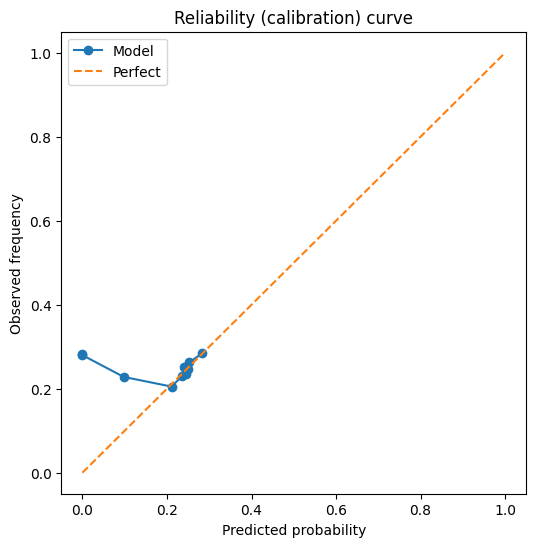

,bin,count,avg_p,hit_rate
0,0,868,0.000,0.282
1,1,868,0.000,0.280
2,2,868,0.098,0.228
3,3,868,0.211,0.205
4,4,868,0.236,0.230
5,5,868,0.240,0.251
6,6,868,0.244,0.234
7,7,868,0.251,0.248
8,8,868,0.253,0.263
9,9,868,0.284,0.285


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pred = pd.read_parquet(processed_dir / "train_predictions.parquet")
pred = pred.rename(columns={"prob_yrfi": "p", "yrfi": "y"})

# Deciles by predicted prob
q = pd.qcut(pred["p"].rank(method="first") / len(pred), q=10, labels=False)
cal = (pd.DataFrame({"y": pred["y"].astype(int), "p": pred["p"], "bin": q})
         .groupby("bin", observed=True)
         .agg(count=("y", "size"), avg_p=("p", "mean"), hit_rate=("y", "mean"))
         .reset_index())

# Plot reliability
plt.figure(figsize=(6, 6))
plt.plot(cal["avg_p"], cal["hit_rate"], marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Reliability (calibration) curve")
plt.legend()
plt.show()

# Show the decile table
cal_style = cal.copy()
cal_style["avg_p"] = cal_style["avg_p"].map("{:.3f}".format)
cal_style["hit_rate"] = cal_style["hit_rate"].map("{:.3f}".format)
display(cal_style)


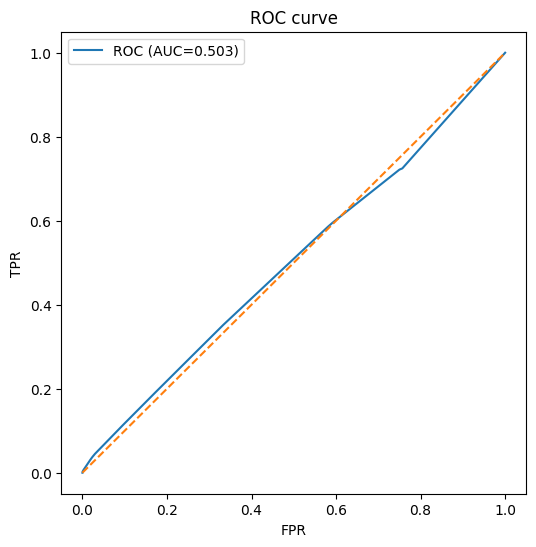

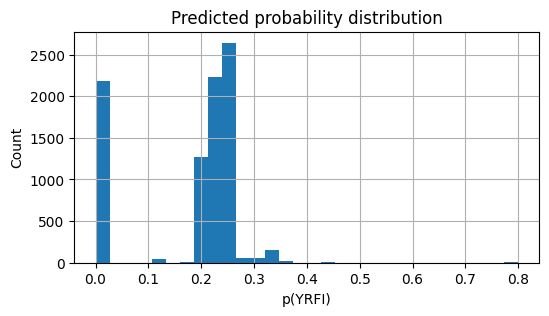

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

auc = roc_auc_score(pred["y"], pred["p"])
fpr, tpr, _ = roc_curve(pred["y"], pred["p"])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
pred["p"].hist(bins=30)
plt.title("Predicted probability distribution")
plt.xlabel("p(YRFI)")
plt.ylabel("Count")
plt.show()
